# DeepNN for Sink Particles
> Created Oct. 2024 <br>
> Nikhil Bisht<br>

In [1]:
# standard system modules
import os, sys

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard statistical module
import scipy.stats as st

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn


# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

## Constants

In [2]:
DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/final_88/nb101_ML_dataset.csv'
MODELFILE = 'nnmodel.dict'

NTRAIN = 1600000
NVALID =  100000
NTEST  =  300000 #roughly

TARGET = ['O_Clump_X', 'O_Clump_Y',	'O_Clump_Z', 'O_Clump_Vx', 'O_Clump_Vy', 'O_Clump_Vz', 'O_Clump_density','O_t_end']
FEATURES = ['X', 'Y', 'Z', 'Density', 'Vx', 'Vy', 'Vz', 't_hard']

n_input = len(FEATURES)
n_output = len(TARGET)

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')
print(n_input, n_output)

Available device: cpu 
8 8


## Load data

In [3]:
df = pd.read_csv(DATAFILE)
print(len(df))
df = df.sample(frac=1).reset_index(drop=True)
df.head()

2097152


,Unnamed: 0,Clump_id,Particle_id,X,Y,Z,Density,Vx,Vy,Vz,t_hard,O_Clump_X,O_Clump_Y,O_Clump_Z,O_Clump_Vx,O_Clump_Vy,O_Clump_Vz,O_Clump_density,O_t_end
0,325643,-1,765198.0,0.998508,0.953404,0.897660,0.279144,-6.064194,0.293609,-1.328493,0.403104,0.932550,0.946430,0.891439,-7.100963,-0.826690,-0.527203,0.278950,0.66003
1,492523,-1,22465.0,0.963346,0.239255,0.921146,1.553199,-4.098066,3.169495,-1.430379,0.403104,0.935869,0.267055,0.914330,-1.835060,2.208904,0.159224,2.434835,0.66003
2,1411925,-1,1380389.0,0.778422,0.464142,0.106891,1.520767,1.188540,-0.396697,-0.646966,0.403104,0.794603,0.462929,0.101088,1.407372,-0.610101,-0.605965,1.954776,0.66003
3,782762,-1,1194206.0,0.292299,0.365011,0.592555,0.188493,-3.397422,7.727718,-3.852727,0.403104,0.278276,0.443328,0.532849,0.106909,7.720485,-6.933946,0.318971,0.66003
4,927135,-1,1500421.0,0.574521,0.607894,0.297512,1.061868,-1.778870,-3.988987,-5.200574,0.403104,0.570212,0.564581,0.260894,0.474468,-4.142699,-2.794758,4.765884,0.66003


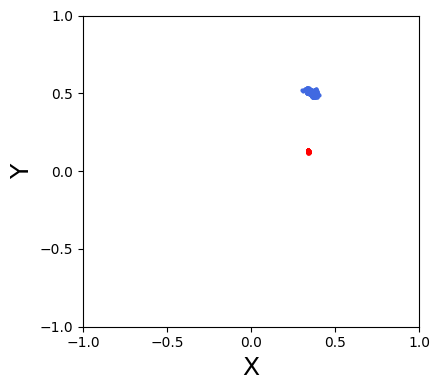

In [4]:
def plot_data():
    
    fig = plt.figure(figsize=(4.5, 4))
    
    ax  = fig.add_subplot(111)
    
    tickmarks = [-1.0, -0.5, 0.0, 0.5, 1.0]
    
    ax.set_xlim(0, 1)
    ax.set_xlabel('X', fontsize=18)
    ax.set_xticks(tickmarks)
    
    ax.set_ylim(0, 1)
    ax.set_ylabel('Y', fontsize=18)
    ax.set_yticks(tickmarks)
    
    d1 = df[df.Clump_id ==2]
    xp, yp = d1.X[:1000], d1.Y[:1000]
    ax.scatter(xp, yp, s=4.0, color='red')
    
    d2 = df[df.Clump_id ==31]
    xp, yp = d2.X[:1000], d2.Y[:1000]
    ax.scatter(xp, yp, s=4.0, color='royalblue');
    
    fig.tight_layout()
    
    plt.show()

plot_data()

## Split data

In [5]:
train_data  = df[:NTRAIN]
print(len(train_data))

valid_data  = df[NTRAIN:NTRAIN+NVALID]
print(len(valid_data))

test_data = df[NTRAIN+NVALID:]
print(len(test_data))

1600000
100000
397152


## Convert to tensors

In [6]:
def dataframe2tensor(df, target, source):
    # change from pandas dataframe to PyTorch tensors
    # and load data to device.
    x = torch.tensor(df[source].to_numpy()).float().to(DEVICE)
    y = torch.tensor(df[target].to_numpy()).float().to(DEVICE)
    return x, y

train_x, train_y = dataframe2tensor(train_data, TARGET, FEATURES)
valid_x, valid_y = dataframe2tensor(valid_data, TARGET, FEATURES)
test_x,  test_y  = dataframe2tensor(test_data,  TARGET, FEATURES)

train_x.shape, train_y.shape

(torch.Size([1600000, 8]), torch.Size([1600000, 8]))

## Some ML Utilities

In [48]:
def get_batch(x, y, batch_size, ii):
    # cycle through batches of training data sequentially
    K = int(len(x) / batch_size + 0.5) # number of batches / epoch
    jj = ii % K
    start = jj * batch_size
    end = start + batch_size - 1
    if end > len(x)-1:
        end = len(x)-1
    return x[start: end+1], y[start: end+1], jj

def get_random_batch(x, y, batch_size):
    # selects at random "batch_size" integers from 
    # the range [0, batch_size-1] corresponding to the
    # row indices of the training data
    rows = torch.randint(0, len(x)-1, size=(batch_size,))
    return x[rows], y[rows]
        
def validate(model, avloss, x, y):
    # set to evaluation mode so that any training 
    # specific operations are disabled.
    model.eval()
    with torch.no_grad(): # no need to compute gradients wrt. x and y
        # reshape to ensure that f and y are of the same shape!
        f = model(x).reshape(y.shape)
    return avloss(f, y)

def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_loss_curve(losses,hyperparam):
    
    xx, yy_t, yy_v = losses
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 3.8))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    
    ax.plot(xx, yy_t, color='red',  lw=1, label='training loss')
    ax.plot(xx, yy_v, color='blue', lw=1, label='validation loss')
    ax.set_title("H: "+str(hyperparam))
    ax.legend()
    
    ax.set_xlabel('iterations')
    ax.set_ylabel('average loss')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')

    name_str = ''
    for hi in range(len(hyperparam)):
        name_str += '_H'+str(hi+1)+'_'+str(hyperparam[hi])
    plt.savefig("../../plots_to_sort/ANN_Losses/2_Layer_model"+name_str+".png")
    plt.close()

## Define the fully-connected neural network

### $\texttt{ReLU}(x)$

$$\text{Relu}(x) = max(0, z)$$


### LayerNorm

$$y = \frac{(x - E[x])}{\sqrt{V(x)}},$$

where the averaging is over the layer.

In [49]:
#%%writefile nnmodel.py
def define_and_train_model(H=[2], n_iterations  = 25000, n_epochs = 1):
    try:
        del model
    except:
        print("No model to delete")
    import torch.nn as nn
    n_input = 8
    n_output = 8
    #model = nn.Sequential(nn.Linear(n_input, H), nn.ReLU(), nn.BatchNorm1d(H), nn.Dropout(0.2),
    #                    nn.Linear(H, 2*H), nn.ReLU(), nn.BatchNorm1d(2*H), nn.Dropout(0.3),
    #                    nn.Linear(2*H, H), nn.ReLU(), nn.BatchNorm1d(H),
    #                    nn.Linear(H, int(H/2)), nn.ReLU(),
    #                    nn.Linear(int(H/2), n_output))
    model = nn.Sequential(nn.Linear(n_input, H[0]), nn.ReLU(), nn.BatchNorm1d(H[0]), nn.Dropout(0.2),
                        nn.Linear(H[0], H[1]), nn.ReLU(), nn.BatchNorm1d(H[1]), nn.Dropout(0.3),
                        nn.Linear(H[1], n_output))
    #from nnmodel import model

    learning_rate = 1.e-4
    optimizer     = torch.optim.Adam(model.parameters(), lr=learning_rate) 

    n_batch  = 32
    n_step   = 10
    n_valid  = len(valid_x)
    train_x2 = train_x[:n_valid]
    train_y2 = train_y[:n_valid]

    emprisk  = nn.HuberLoss(delta=0.0005)
    #print(number_of_parameters(model),model)
    # Train model
    USE_SEQUENTIAL_BATCHES = True

    epoch = 0

    X = []
    T = []
    V = []

    min_avloss = float('inf')

    while epoch<n_epochs:
        for ii in range(n_iterations):

            # clear previous gradients
            
            optimizer.zero_grad()
            
            # set mode to training so that training specific 
            # operations such as dropout are enabled.
            
            model.train()

            # get a batch of data 

            if USE_SEQUENTIAL_BATCHES:
                x, y, jj = get_batch(train_x, train_y, n_batch, ii)
                if jj == 0:
                    epoch += 1
            else:
                x, y = get_random_batch(train_x, train_y, n_batch)  
            
            f = model(x).reshape(y.shape)

            R = emprisk(f, y)
            
            R.backward()  # compute gradients of with respect to NN parameters

            optimizer.step()    # advance one step in the space of NN parameters

            if ii % n_step == 0:
                
                t_loss = validate(model, emprisk, train_x2, train_y2).detach()
                v_loss = validate(model, emprisk, valid_x,  valid_y).detach()

                print(f'\r|{epoch:9d}|{ii:9d}|{t_loss:9.3e}|{v_loss:9.3e}|', end='')

                X.append(ii)
                T.append(float(t_loss))
                V.append(float(v_loss))

                if v_loss < 0.995 * min_avloss:
                    min_avloss = v_loss
                    torch.save(model.state_dict(), MODELFILE)
                
        print()

    plot_loss_curve([X, T, V], H)
    return model,emprisk

In [51]:
import sklearn.metrics as skm
best_model_arr = []
#hyperparam_value H = 4 for 4 layer
#hyperparam_value H = 2 for 3 layer
#hyperparam_value H = 8 for 2 layer
#hyperparam_value H = 8 for 1 layer
#hyperparam_value H1,H2 = 5,9 for 2 layer

for hyperparam_value1 in range(5,10):
    for hyperparam_value2 in range(5,10):
        model,emprisk = define_and_train_model([hyperparam_value1,hyperparam_value2])
        # standard measures of model performance
        # set to evaluation mode so that any training 
        # specific operations are disabled.
        model.eval()
        with torch.no_grad(): # no need to compute gradients wrt. x and y
            # reshape to ensure that f and y are of the same shape!
            f = model(test_x).reshape(test_y.shape)
        v_loss = emprisk(f, test_y).detach()
        rmse = skm.root_mean_squared_error(test_y,f.detach())
        r2 = skm.r2_score(test_y,f.detach())
        best_model_arr.append([[hyperparam_value1,hyperparam_value2],v_loss,rmse,r2])
best_model_arr

No model to delete
|        1|    24990|8.005e-02|8.125e-02|
No model to delete
|        1|    24990|8.007e-02|8.127e-02|
No model to delete
|        1|    24990|8.009e-02|8.128e-02|
No model to delete
|        1|    24990|8.012e-02|8.133e-02|
No model to delete
|        1|    24990|8.000e-02|8.121e-02|
No model to delete
|        1|    24990|8.008e-02|8.128e-02|
No model to delete
|        1|    24990|8.006e-02|8.126e-02|
No model to delete
|        1|    24990|8.012e-02|8.133e-02|
No model to delete
|        1|    24990|8.005e-02|8.125e-02|
No model to delete
|        1|    24990|8.013e-02|8.134e-02|
No model to delete
|        1|    24990|8.005e-02|8.125e-02|
No model to delete
|        1|    24990|8.014e-02|8.135e-02|
No model to delete
|        1|    24990|8.009e-02|8.130e-02|
No model to delete
|        1|    24990|8.008e-02|8.128e-02|
No model to delete
|        1|    24990|8.000e-02|8.120e-02|
No model to delete
|        1|    24990|8.008e-02|8.128e-02|
No model to delete
|    

[[[5, 5], tensor(0.0776), np.float32(2482.8984), -1.6226172014719908],
 [[5, 6], tensor(0.0777), np.float32(2481.592), 0.25303606290128516],
 [[5, 7], tensor(0.0777), np.float32(2482.1487), -0.2996039180969296],
 [[5, 8], tensor(0.0777), np.float32(2482.1055), -0.5151293918434399],
 [[5, 9], tensor(0.0776), np.float32(2481.299), 0.2139441817724459],
 [[6, 5], tensor(0.0777), np.float32(2481.6353), -0.02578643653089019],
 [[6, 6], tensor(0.0777), np.float32(2481.8103), -0.021682744261394535],
 [[6, 7], tensor(0.0777), np.float32(2481.6094), -0.3780484029133032],
 [[6, 8], tensor(0.0776), np.float32(2481.4897), -0.0187348698969481],
 [[6, 9], tensor(0.0777), np.float32(2481.2527), 0.08423104313290207],
 [[7, 5], tensor(0.0776), np.float32(2481.6848), 0.127852157941224],
 [[7, 6], tensor(0.0777), np.float32(2481.371), 0.08874563881907689],
 [[7, 7], tensor(0.0777), np.float32(2481.769), -0.3337645075571757],
 [[7, 8], tensor(0.0777), np.float32(2481.8896), -0.3835855775659903],
 [[7, 9], 